In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [ ]:
torch.__version__

'2.1.1+cu121'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
    SentencePairDataset,
    MultSentencesPairDataset,
    MultOverlappingSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy
from text_embeddings_src.embeddings import generate_embeddings

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [ ]:
plt.style.use("matplotlib_style.txt")

# Import

## Data

In [ ]:
# %%time
# compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

# iclr = pd.read_pickle(
#     data_path / "iclr.pickle.zip",
#     # index_col=False,
#     compression=compression_opts,
# )

In [ ]:
iclr = pd.read_parquet(
    data_path / "iclr.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

In [ ]:
iclr.keywords = iclr.keywords.transform(lambda x: list(x))
iclr.scores = iclr.scores.transform(lambda x: list(x))

In [ ]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


In [ ]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

In [ ]:
print(len(titles_abstracts_together))

16536


## Labels

In [ ]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


In [ ]:
type(iclr_labeled["y"])

pandas.core.series.Series

# SentencePairDataset

## Understanding what he does in the sentence_map

In [ ]:
abstracts = iclr.abstract  # .to_list()

In [ ]:
abstracts[0]

"In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy."

In [ ]:
abstracts[0].split(".")

['In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly',
 " We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process",
 ' First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes',
 " Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location",
 ' Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior',
 ' We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy',
 '']

In [ ]:
test_out = abstracts.map(lambda a: a.split("."))

Object `split()` not found.


In [ ]:
test_out

0        [In cities with tall buildings, emergency resp...
1        [We consider the problem of exploration in met...
2        [We present Merged-Averaged Classifiers via Ha...
3        [The goal of imitation learning (IL) is to ena...
4        [The choice of activation functions in deep ne...
                               ...                        
16531    [Combined with the generative prior of pre-tra...
16532    [We define \emph{laziness} to describe a large...
16533    [Most graph neural networks (GNNs) rely on the...
16534    [We study the ability of one layer Graph Atten...
16535    [GANs have two competing modules: the generato...
Name: abstract, Length: 16536, dtype: object

In [ ]:
sentences_0 = test_out[0]
for s in sentences_0:
    # if len(s) >= 100:
    print(s.strip() + ".")

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.
We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.
First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes.
Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location.
Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior.
We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.
.


In [ ]:
len(sentences_0[-1])

0

In [ ]:
sentences_0 = test_out[0]
for s in sentences_0:
    if len(s) >= 100:
        print(s.strip() + ".")

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.
We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.
First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes.
Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location.
Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior.
We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.


In [ ]:
sentences_map = {
    s.strip() + ".": i
    for i, sentences in enumerate(abstracts.map(lambda a: a.split(".")))
    for s in sentences
    if len(s) >= 100
}

## Sentence length distribution

In [ ]:
abstracts_list_sentences = abstracts.map(lambda a: a.split(".")).to_list()

In [ ]:
np.hstack(abstracts_list_sentences)  # ][0]

array(['In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly',
       " We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process",
       ' First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes',
       ...,
       ' We observed that each module can perform better and learn faster if training is modeled as an infinitely repeated simultaneous game',
       ' At every repetition of the base game (at every batch of training data) the stronger module (whose performance is increased or remains the same compared to the previous batch of training data) cooperates with the weaker module (whose performance is decreased compared to the previous batch of training data) and only the weaker module is allowed to increase its performance',
       ''], dtype='<U981')

In [ ]:
len(np.hstack(abstracts_list_sentences))

153076

In [ ]:
%%time
len_sentences_characters = [
    len(x) for x in np.hstack(abstracts_list_sentences)
]

CPU times: user 593 ms, sys: 119 ms, total: 711 ms
Wall time: 712 ms


In [ ]:
len_sentences_characters = np.array(len_sentences_characters)

In [ ]:
print(np.amax(len_sentences_characters))
print(np.amin(len_sentences_characters))

981
0


In [ ]:
bin_edges_characters = np.arange(0, 1000, 10)

In [ ]:
%%time

counts_characters, bins_characters = np.histogram(
    len_sentences_characters, bins=bin_edges_characters
)

CPU times: user 6.61 ms, sys: 457 µs, total: 7.07 ms
Wall time: 6.21 ms


Text(0.5, 0, 'Number of abstract characters')

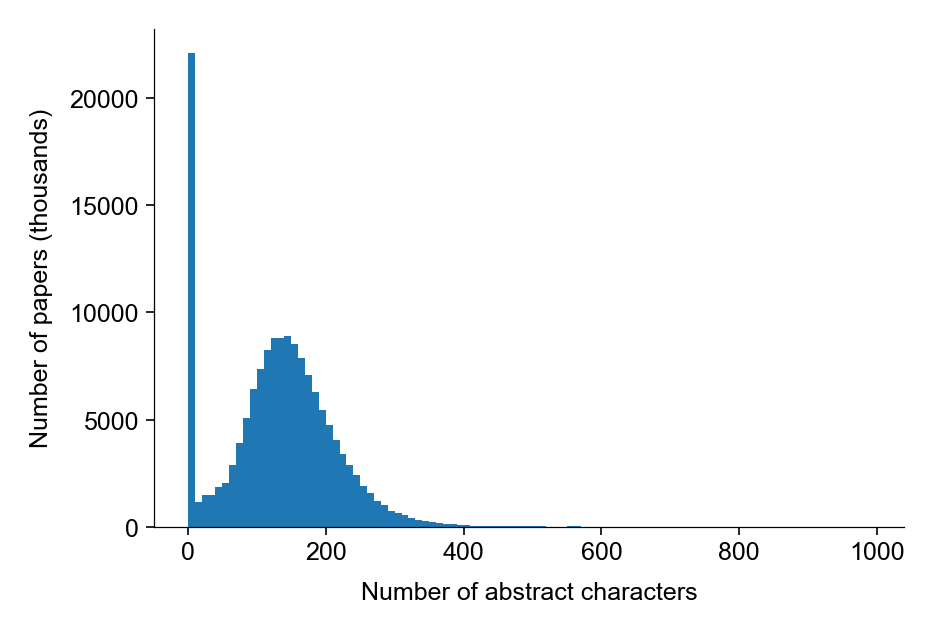

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.hist(bins_characters[:-1], bins_characters, weights=counts_characters)
ax.set_ylabel("Number of papers (thousands)")
ax.set_xlabel("Number of abstract characters")
# ax.set_yticks(np.arange(0, 400, 50) * 1000)
# ax.set_yticklabels(np.arange(0, 400, 50))
# ax.set_xlim(0, 3500)
# ax.set_ylim(0, 350 * 1e3)

In [ ]:
lens, counts = np.unique(len_sentences_characters, return_counts=True)

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters > 250) | (len_sentences_characters <= 100)
    ]
) / len(np.hstack(abstracts_list_sentences)) * 100

38.401186338812096

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[(len_sentences_characters <= 100)]
) / len(np.hstack(abstracts_list_sentences)) * 100

32.062504899527035

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters >= 100) & (len_sentences_characters <= 250)
    ]
) / len(np.hstack(abstracts_list_sentences)) * 100

62.050876688703646

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters >= 100) & (len_sentences_characters <= 250)
    ]
)

94985

## Number of contrastive pairs

In [ ]:
abstracts = iclr.abstract  # .to_list()

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SentencePairDataset(
    iclr.abstract, tokenizer, device, seed=42
)

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
print(len(training_dataset))

16407


# MultSentencesPairDataset

In [ ]:
n_cons_sntcs = 2
regex_block = r".{5,}?\."
_regex = regex_block
for i in range(n_cons_sntcs - 1):
    _regex += r"\s" + regex_block

In [ ]:
import re

_regex

'.{5,}\\.\\s.{5,}\\.'

In [ ]:
s = ". My name is Rita.  I am 25 zears old.  i AM SO COOL. you cannot believe it."
re.findall(_regex, s, flags=re.S)

['. My name is Rita.  I am 25 zears old.  i AM SO COOL. you cannot believe it.']

In [ ]:
r = r"b[abc]{3,}?c"
s = "baaaacabaaac"
re.findall(r, s)

['baaaac', 'baaac']

## Two-sentences length distribution (n_cons_sntcs=2)

In [ ]:
abstracts = iclr.abstract  # .to_list()

In [ ]:
n_cons_sntcs = 2
regex_block = r".{5,}?\."
_regex = regex_block
for i in range(n_cons_sntcs - 1):
    _regex += r"\s" + regex_block

In [ ]:
sentences_map = [
    (s.strip() + ".", i)
    for i, sentences in enumerate(
        abstracts[:1].map(lambda a: re.findall(_regex, a, flags=re.S))
    )
    for s in sentences
    if (len(s) >= 100 * n_cons_sntcs)
    & (len(s) <= 250 * n_cons_sntcs)  # limit the sentence lengths
]

sentences_map

[("In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process..",
  0),
 ("First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location..",
  0),
 ('Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy..',
  0)]

In [ ]:
abstracts_list_sentences = abstracts.map(
    lambda a: re.findall(_regex, a, flags=re.S)
).to_list()

In [ ]:
abstracts_list_sentences[0][1].strip()  # ][0]

"First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location."

In [ ]:
len(np.hstack(abstracts_list_sentences))

59003

In [ ]:
%%time
len_sentences_characters = [
    len(x) for x in np.hstack(abstracts_list_sentences)
]

CPU times: user 309 ms, sys: 708 µs, total: 309 ms
Wall time: 309 ms


In [ ]:
len_sentences_characters = np.array(len_sentences_characters)

In [ ]:
print(np.amax(len_sentences_characters))
print(np.amin(len_sentences_characters))

1209
15


In [ ]:
bin_edges_characters = np.arange(0, 1220, 10)

In [ ]:
%%time

counts_characters, bins_characters = np.histogram(
    len_sentences_characters, bins=bin_edges_characters
)

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 2.78 ms


Text(0.5, 0, 'Number of abstract characters')

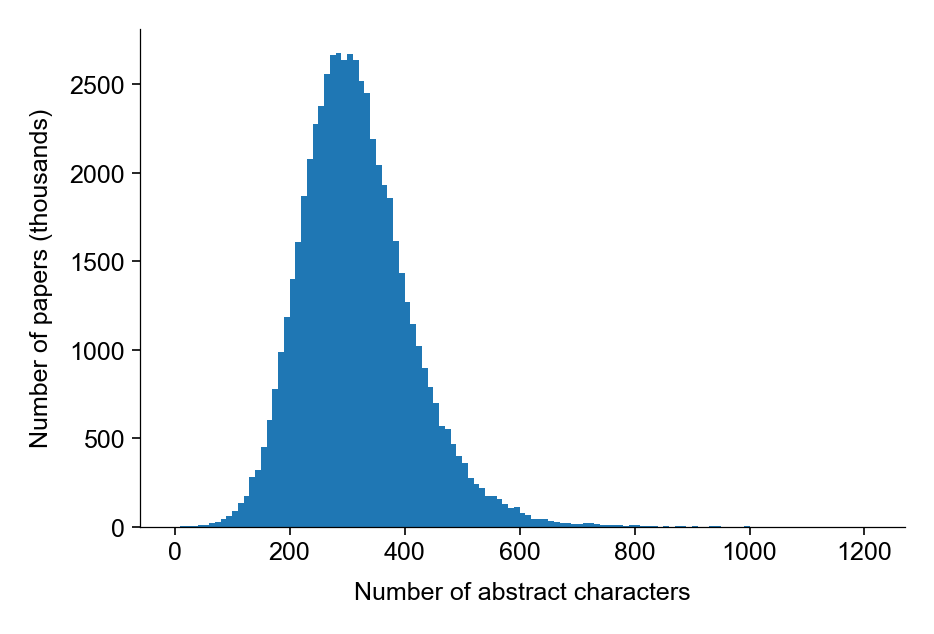

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.hist(bins_characters[:-1], bins_characters, weights=counts_characters)
ax.set_ylabel("Number of papers (thousands)")
ax.set_xlabel("Number of abstract characters")
# ax.set_yticks(np.arange(0, 400, 50) * 1000)
# ax.set_yticklabels(np.arange(0, 400, 50))
# ax.set_xlim(0, 3500)
# ax.set_ylim(0, 350 * 1e3)

In [ ]:
np.hstack(abstracts_list_sentences)[
    (len_sentences_characters < 200) & (len_sentences_characters >= 150)
][
    :5
]  # [-1# .strip()

array([" Results are presented on a novel environment we call 'Krazy World'  and a set of maze environments. We show E-MAML and ERL2 deliver better performance on tasks where exploration is important.",
       '9% for Mobile NASNet-A and 0.6% for Inception-ResNet-v2. The simplicity of Swish and its similarity to ReLU make it easy for practitioners to replace ReLUs with Swish units in any neural network.',
       'e. for every image from domain A find an analogous image in domain B. We present a matching-by-synthesis approach: AN-GAN, and show that it outperforms current techniques.',
       'Relational databases store a significant amount of the worlds data. However, accessing this data currently requires users to understand a query language such as SQL.',
       ' At inference time, it finds a close output to a given image which does not contain the adversarial changes. This output is then fed to the classifier.'],
      dtype='<U1209')

In [ ]:
np.hstack(abstracts_list_sentences)[
    (len_sentences_characters == 500)  # & (len_sentences_characters >= 150)
][
    :10
]  # [-1# .strip()

array([' This leads to a new theoretical result about LSTMs: low-dimensional embeddings derived from a low-memory LSTM are provably at least as powerful on classification tasks, up to small error, as a linear classifier over BonG vectors, a result that extensive empirical work has thus far been unable to show. Our experiments support these theoretical findings and establish strong, simple, and unsupervised baselines on standard benchmarks that in some cases are state of the art among word-level methods.',
       ' To improve overall generalization, all types of variations in the environment have to be taken under consideration via different level of data augmentation steps. To this end, we propose House3D, a rich, extensible and efficient environment that contains 45,622 human-designed 3D scenes of visually realistic houses, ranging from single-room studios to multi-storied houses, equipped with a diverse set of fully labeled 3D objects, textures and scene layouts, based on the SUNCG d

In [ ]:
lens, counts = np.unique(len_sentences_characters, return_counts=True)

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters > 250) | (len_sentences_characters <= 100)
    ]
) / len(np.hstack(abstracts_list_sentences)) * 100

38.401186338812096

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[(len_sentences_characters <= 100)]
) / len(np.hstack(abstracts_list_sentences)) * 100

32.062504899527035

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters >= 100) & (len_sentences_characters <= 250)
    ]
) / len(np.hstack(abstracts_list_sentences)) * 100

62.050876688703646

In [ ]:
len(
    np.hstack(abstracts_list_sentences)[
        (len_sentences_characters >= 100) & (len_sentences_characters <= 250)
    ]
)

94985

## Number of contrastive pairs for n_cons_sntcs=3

In [ ]:
abstracts = iclr.abstract  # .to_list()

In [ ]:
n_cons_sntcs = 3
regex_block = r".{5,}?\."
_regex = regex_block
for i in range(n_cons_sntcs - 1):
    _regex += r"\s" + regex_block

In [ ]:
abstracts_list_sentences = abstracts.map(
    lambda a: re.findall(_regex, a, flags=re.S)
).to_list()

In [ ]:
abstracts_list_sentences[0][1].strip()  # ][0]

"First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location."

In [ ]:
len(np.hstack(abstracts_list_sentences))

36177

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=3, seed=42
)

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
print(len(training_dataset))

12810


## Distribution of n of sentences per abstract

In [ ]:
abstracts = iclr.abstract

In [ ]:
test_out = abstracts.map(lambda a: a.split("."))

In [ ]:
len(test_out)

16536

In [ ]:
n_sentences_per_abstract = [len(elem) for elem in test_out]

In [ ]:
print(np.amax(n_sentences_per_abstract))
print(np.amin(n_sentences_per_abstract))

41
2


In [ ]:
bin_edges_characters = np.arange(0, 42, 1)

In [ ]:
%%time

counts_characters, bins_characters = np.histogram(
    n_sentences_per_abstract, bins=bin_edges_characters
)

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.43 ms


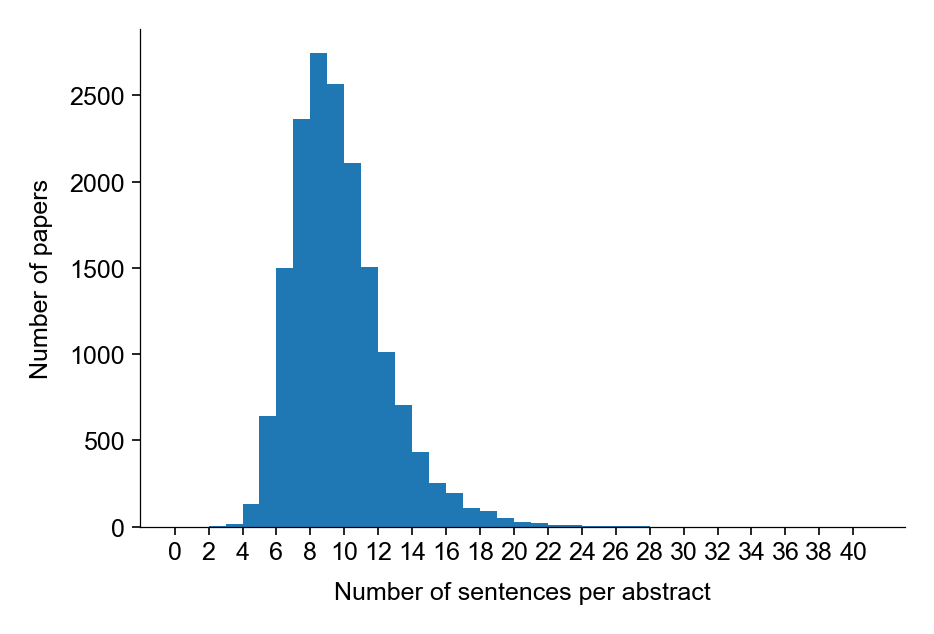

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.hist(bins_characters[:-1], bins_characters, weights=counts_characters)
ax.set_ylabel("Number of papers")
ax.set_xlabel("Number of sentences per abstract")
ax.set_xticks(np.arange(0, 42, 2))

fig.savefig(variables_path / "n_sentences_per_abstract.png")

In [ ]:
print(
    np.sum(np.array(n_sentences_per_abstract) >= 2)
    / len(n_sentences_per_abstract)
    * 100
)
print(
    "Number of total sentences in the dataset: ",
    np.sum(np.array(n_sentences_per_abstract)),
)
print("Number of abstracts: ", len(n_sentences_per_abstract))
print(
    "Number of abstracts with more than 2 sentences: ",
    np.sum(np.array(n_sentences_per_abstract) >= 2),
)

100.0
Number of total sentences in the dataset:  153076
Number of abstracts:  16536
Number of abstracts with more than 2 sentences:  16536


In [ ]:
print(
    np.sum(np.array(n_sentences_per_abstract) >= 4)
    / len(n_sentences_per_abstract)
    * 100
)
print("Number of abstracts: ", len(n_sentences_per_abstract))
print(
    "Number of abstracts with more than 10 sentences: ",
    np.sum(np.array(n_sentences_per_abstract) >= 4),
)

99.87905176584422
Number of abstracts:  16536
Number of abstracts with more than 10 sentences:  16516


In [ ]:
print(
    np.sum(np.array(n_sentences_per_abstract) >= 6)
    / len(n_sentences_per_abstract)
    * 100
)
print("Number of abstracts: ", len(n_sentences_per_abstract))
print(
    "Number of abstracts with more than 6 sentences: ",
    np.sum(np.array(n_sentences_per_abstract) >= 6),
)

95.20440251572327
Number of abstracts:  16536
Number of abstracts with more than 6 sentences:  15743


In [ ]:
print(
    np.sum(np.array(n_sentences_per_abstract) >= 10)
    / len(n_sentences_per_abstract)
    * 100
)
print("Number of abstracts: ", len(n_sentences_per_abstract))
print(
    "Number of abstracts with more than 10 sentences: ",
    np.sum(np.array(n_sentences_per_abstract) >= 10),
)

39.71335268505079
Number of abstracts:  16536
Number of abstracts with more than 10 sentences:  6567


# MultOverlappingSentencesPairDataset

In [ ]:
self.abstacts = abstracts
self.rng = np.random.default_rng(seed)

sentences_map = [
    (s.strip() + ".", i)
    for i, sentences in enumerate(
        abstracts.map(lambda a: a.split("."))
    )
    for s in sentences
    if (len(s) >= 100) & (len(s) <= 250)  #limit the sentence lengths
]

for key, group in itertools.groupby(
        sentences_and_toks,
        key=lambda kvtoksetc: kvtoksetc[0][1],
    ):
        grp = list(group)
        if len(grp) < 2:
            continue  # not enough sentences
        else:
             abs_sentences.append([kv[0] for kv in grp])
             abs_toks.append([x[1] for x in grp])
            self.abs_amsk.append([x[2] for x in grp])


In [ ]:
abstracts = iclr.abstract

In [ ]:
test_out = abstracts.map(lambda a: a.split("."))

In [ ]:
test_abstract = [elem.strip() + "." for elem in test_out[0]]

In [ ]:
for sntc in test_abstract:
    print(sntc)

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.
We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.
First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes.
Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location.
Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior.
We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.
.


In [ ]:
np.random.seed(12)
subset = np.random.choice(pubmed.AbstractText.shape[0], size=iclr.abstract.shape[0], replace=False)
test_abstract

In [ ]:
dummy_abstract = ["A", "B", "C", "D", "E"]

In [ ]:
for i in range(len(dummy_abstract) - 1):
    print(dummy_abstract[i], dummy_abstract[i + 1])

A B
B C
C D
D E


In [ ]:
i = 0
(dummy_abstract[i] + dummy_abstract[i + 1]).strip() + "."

'AB.'

In [ ]:
# dummy_abstracts = [["A", "B", "C", "D", "E"], ["H", "I", "J", "K", "L", "M"]]
dummy_abstracts = pd.Series(["A.B.C.D.E.", "H.I.J.K.L.M."])
print(len(dummy_abstracts))

2


In [ ]:
%%time
sentences_map = [
    ((sentences[j] + sentences[j + 1]).strip() + ".", i)
    for i, sentences in enumerate(dummy_abstracts.map(lambda a: a.split(".")))
    for j in range(len(sentences) - 1)
    if (
        len(sentences[j] + sentences[j + 1]) >= 2
    )  # & (len(s) <= 250)  #limit the sentence lengths
]
sentences_map

CPU times: user 438 µs, sys: 0 ns, total: 438 µs
Wall time: 453 µs


[('AB.', 0),
 ('BC.', 0),
 ('CD.', 0),
 ('DE.', 0),
 ('HI.', 1),
 ('IJ.', 1),
 ('JK.', 1),
 ('KL.', 1),
 ('LM.', 1)]

In [ ]:
sentences_map = [
    (sentences[j].strip() + ". " + sentences[j + 1].strip() + ".", i)
    for i, sentences in enumerate(abstracts[:1].map(lambda a: a.split(".")))
    for j in range(len(sentences) - 1)
    if (
        (len(sentences[j]) >= 1) & (len(sentences[j + 1]) >= 1)
    )  # & (len(s) <= 250)  #limit the sentence lengths
]
sentences_map

[("In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.",
  0),
 ("We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes.",
  0),
 ("First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location.",
  0),
 ("Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. Unlike impractical previous approaches, our system is the fir

In [ ]:
dummy_abstracts_2 = pd.Series(["A.B..D.E.", "H..J..L.M."])
print(len(dummy_abstracts))

2


In [ ]:
# v1 -- BUENO
# does not take pair BD if there is some shorter sentence in between
n_cons_sntcs = 2
sentence_map = []
for i, sentences in enumerate(
    dummy_abstracts_2[:1].map(lambda a: a.split("."))
):
    for j in range(
        len(sentences) - (n_cons_sntcs - 1)
    ):  # loop through the next consecutive sentences (only n_cons_sntcs)
        sentences_pack = ""
        exceptions_count = 0
        for k in range(n_cons_sntcs):
            if len(sentences[j + k]) >= 1:
                sentences_pack += sentences[j + k].strip() + ". "
            else:
                exceptions_count += 1
        if exceptions_count == 0:
            sentence_map.append((sentences_pack, i))
sentence_map

[('A. B. ', 0), ('D. E. ', 0)]

In [ ]:
%%time
# v2 --BUENO
# takes pair BD if there is some shorter sentence in between
n_cons_sntcs = 1
sentence_map = []

for i, sentences in enumerate(
    dummy_abstracts_2.map(lambda a: a.split("."))
):  # loop through abstracts
    for j in range(
        len(sentences) - (n_cons_sntcs - 1)
    ):  # loop through sentences inside abstract
        if len(sentences[j]) >= 1:  # length conditions
            cons_sentences_pack = ""
            cons_sentence_counts = 0
            for k in range(
                len(sentences) - j
            ):  # loop through sentences to add them
                if len(sentences[j + k]) >= 1:  # length conditions
                    cons_sentences_pack += sentences[j + k].strip() + ". "
                    cons_sentence_counts += 1

                if (
                    cons_sentence_counts == n_cons_sntcs
                ):  # check if we have already enough sentences
                    sentence_map.append((cons_sentences_pack, i))
                    break

sentence_map

CPU times: user 443 µs, sys: 0 ns, total: 443 µs
Wall time: 472 µs


[('A. ', 0),
 ('B. ', 0),
 ('D. ', 0),
 ('E. ', 0),
 ('H. ', 1),
 ('J. ', 1),
 ('L. ', 1),
 ('M. ', 1)]

In [ ]:
n_cons_sntcs = 1
sentence_map = []

for i, sentences in enumerate(
    abstracts[:1].map(lambda a: a.split("."))
):  # loop through abstracts
    for j in range(
        len(sentences) - (n_cons_sntcs - 1)
    ):  # loop through sentences inside abstract
        if len(sentences[j]) >= 1:  # length conditions
            cons_sentences_pack = ""
            cons_sentence_counts = 0
            for k in range(
                len(sentences) - j
            ):  # loop through sentences to add them
                if len(sentences[j + k]) >= 1:  # length conditions
                    cons_sentences_pack += sentences[j + k].strip() + ". "
                    cons_sentence_counts += 1

                if (
                    cons_sentence_counts == n_cons_sntcs
                ):  # check if we have already enough sentences
                    sentence_map.append((cons_sentences_pack, i))
                    break

sentence_map

[('In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. ',
  0),
 ("We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. ",
  0),
 ('First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. ',
  0),
 ("Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. ",
  0),
 ('Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. ',
  0),
 ('We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy. ',
  0)]

### Test with class

In [ ]:
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
%%time
# data
training_dataset = MultSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=3, seed=42
)

CPU times: user 37.2 s, sys: 7.53 s, total: 44.7 s
Wall time: 15 s


In [ ]:
len(training_dataset)

12810

In [ ]:
training_dataset[0]

((tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
           2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
           2015,  2855,  1012,  2057,  8970,  1037,  2291,  2000, 10197,  1037,
           6778,  1005,  1055,  2723,  2504,  3081,  2037,  4684,  5080,  1005,
           1055, 13617,  2951,  1999,  1037,  2048,  1011,  3357,  2832,  1012,
           2034,  1010,  2057,  3345,  1037, 15756,  2897,  2000,  5646,  2043,
           1037, 26381,  8039,  2030, 16639,  1037,  2311,  3081, 14658,  4742,
           3431,  1012,  1012,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=3, seed=42
)

CPU times: user 52.7 s, sys: 12.3 s, total: 1min 5s
Wall time: 5.96 s


In [ ]:
len(training_dataset)

14657

In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=1, seed=42
)

CPU times: user 31.6 s, sys: 12.4 s, total: 44 s
Wall time: 5.82 s


In [ ]:
len(training_dataset)

16407

# AbstractSplitDataset

In [ ]:
abstracts = iclr.abstract  # .to_list()

In [ ]:
abstracts

0        In cities with tall buildings, emergency respo...
1        We consider the problem of exploration in meta...
2        We present Merged-Averaged Classifiers via Has...
3        The goal of imitation learning (IL) is to enab...
4        The choice of activation functions in deep net...
                               ...                        
16531    Combined with the generative prior of pre-trai...
16532    We define \emph{laziness} to describe a large ...
16533    Most graph neural networks (GNNs) rely on the ...
16534    We study the ability of one layer Graph Attent...
16535    GANs have two competing modules: the generator...
Name: abstract, Length: 16536, dtype: object

In [ ]:
import re

In [ ]:
sentences_map = dict()
regex_block = r".{5,}?\."
# for i, (abstract) in enumerate(abstracts):
i = 1
abstract = abstracts[i]

n_sntcs = sum(
    1 for _ in re.finditer(regex_block + r"\s", abstract, flags=re.S)
)
# n_sntcs = abstract.count(".")

_regex = regex_block + "".join(
    [r"\s" + regex_block for _ in range(n_sntcs // 2)]
)

part1 = re.match(_regex, abstract, flags=re.S)[0]
part2 = re.sub(_regex, "", abstract, flags=re.S)
sentences_map[part1] = i
sentences_map[part2] = i

In [ ]:
sentences_map[part]

{'We consider the problem of exploration in meta reinforcement learning. Two new meta reinforcement learning algorithms are suggested: E-MAML and ERL2.': 1,
 '': 1}

# Labels based augmentation

In [ ]:
toy_dataset = ["A.A.A.", "B.B.B.", "C.C.C.", "D.D.D.", "E.E.E."]
toy_labels = ["one", "two", "two", "three", "one"]

toy_dataset = pd.Series(np.array(toy_dataset)[np.argsort(toy_labels)])
toy_labels = np.sort(toy_labels)

print(toy_dataset)
print(toy_labels)

0    A.A.A.
1    E.E.E.
2    D.D.D.
3    B.B.B.
4    C.C.C.
dtype: object
['one' 'one' 'three' 'two' 'two']


In [ ]:
import itertools

for key, group in itertools.groupby(
    zip(toy_dataset, toy_labels),
    key=lambda kvtoksetc: kvtoksetc[1],
):
    print(list(group))

[('A.A.A.', 'one'), ('E.E.E.', 'one')]
[('D.D.D.', 'three')]
[('B.B.B.', 'two'), ('C.C.C.', 'two')]


In [ ]:
n_cons_sntcs = 2
sentence_map = []

for i, sentences in enumerate(
    toy_dataset.map(lambda a: a.split("."))
):  # loop through abstracts
    for j in range(
        len(sentences) - (n_cons_sntcs - 1)
    ):  # loop through sentences inside abstract
        if len(sentences[j]) >= 1:  # length conditions
            cons_sentences_pack = ""
            cons_sentence_counts = 0
            for k in range(
                len(sentences) - j
            ):  # loop through sentences to add them
                if len(sentences[j + k]) >= 1:  # length conditions
                    cons_sentences_pack += sentences[j + k].strip() + ". "
                    cons_sentence_counts += 1

                if (
                    cons_sentence_counts == n_cons_sntcs
                ):  # check if we have already enough sentences
                    sentence_map.append(
                        (cons_sentences_pack, toy_labels[i])
                    )
                    break

sentence_map

[('A. A. ', 0, 'one'),
 ('A. A. ', 0, 'one'),
 ('E. E. ', 1, 'one'),
 ('E. E. ', 1, 'one'),
 ('D. D. ', 2, 'three'),
 ('D. D. ', 2, 'three'),
 ('B. B. ', 3, 'two'),
 ('B. B. ', 3, 'two'),
 ('C. C. ', 4, 'two'),
 ('C. C. ', 4, 'two')]

#### test 2

In [ ]:
toy_dataset = pd.Series(
    ["A.A.X.", "B.B.X.", "C.C.X.", "D.D.X.", "E.E.X.", "F.F.X", "G.G.X."]
)
toy_labels = pd.Series(["one", "two", "two", "three", "one", "one", "two"])

In [ ]:
n_cons_sntcs = 2
sentences_map = []

for i, sentences in enumerate(
    toy_dataset.map(lambda a: a.split("."))
):  # loop through abstracts
    for j in range(
        len(sentences) - (n_cons_sntcs - 1)
    ):  # loop through sentences inside abstract
        if len(sentences[j]) >= 1:  # length conditions
            cons_sentences_pack = ""
            cons_sentence_counts = 0
            for k in range(
                len(sentences) - j
            ):  # loop through sentences to add them
                if len(sentences[j + k]) >= 1:  # length conditions
                    cons_sentences_pack += sentences[j + k].strip() + ". "
                    cons_sentence_counts += 1

                if (
                    cons_sentence_counts == n_cons_sntcs
                ):  # check if we have already enough sentences
                    sentences_map.append(
                        (cons_sentences_pack, i, toy_labels[i])
                    )
                    break

sentences_map

[('A. A. ', 0, 'one'),
 ('A. X. ', 0, 'one'),
 ('B. B. ', 1, 'two'),
 ('B. X. ', 1, 'two'),
 ('C. C. ', 2, 'two'),
 ('C. X. ', 2, 'two'),
 ('D. D. ', 3, 'three'),
 ('D. X. ', 3, 'three'),
 ('E. E. ', 4, 'one'),
 ('E. X. ', 4, 'one'),
 ('F. F. ', 5, 'one'),
 ('F. X. ', 5, 'one'),
 ('G. G. ', 6, 'two'),
 ('G. X. ', 6, 'two')]

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
import itertools

tokenizer_kwargs = dict(
    max_length=512,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

sentences_tok = tokenizer(
    [x for x, _, _ in sentences_map], **tokenizer_kwargs
).to(device)


# we group the flat sentences by the original abstract they
# come from.  Then we can check whether we have enough
# sentences and append the abstracts with at least two
# sentences to our list.
sentences_and_toks = zip(
    sentences_map,
    sentences_tok["input_ids"],
    sentences_tok["attention_mask"],
)
abs_sentences = []  # np.empty(len(toy_dataset))
abs_toks = []
abs_mask = []
for key, group in itertools.groupby(
    sentences_and_toks,
    key=lambda kvtoksetc: kvtoksetc[0][1],
):
    grp = list(group)
    if len(grp) < 2:
        continue  # not enough sentences
    else:
        abs_sentences.append([kv[0] for kv in grp])
        # abs_sentences[key] = [kv[0] for kv in grp]
        abs_toks.append([x[1] for x in grp])
        abs_mask.append([x[2] for x in grp])

In [ ]:
# rng = np.random.default_rng(42)
# idx = 0
# abstract_info = abs_sentences[idx]

# print(abstract_info)
# abstract_tok = abs_toks[idx]
# print(abstract_tok)
# amask = abs_amsk[idx]
# print(amask)
# print("------------")
# # from asbtract info I can get the label and the abst number, but now we asume we know them
# label = "one"
# abstract_indx = 0

# abstracts_same_label = [
#     elem
#     for i, elem in enumerate(zip(abs_sentences, abs_toks, abs_amsk))
#     if (toy_labels[i] == label)
#     # & (elem[0][0][1] != abstract_indx)  # toy labels would be elem[0][0][2]
# ]

# print(len(abstracts_same_label))
# abstracts_same_label[0]
# iabstract = rng.choice(len(abstracts_same_label), replace=False)
# print(iabstract)
# print(abstracts_same_label[iabstract])
# isentence = rng.choice(len(abstracts_same_label[iabstract][0]), replace=False)
# print(isentence)
# output = [elem[isentence] for elem in abstracts_same_label[iabstract]]
# print(output)

In [ ]:
%%time
# same thing as above but clean
rng = np.random.default_rng(42)
idx = 0
isentence2 = rng.choice(len(abs_sentences[idx]), replace=False)
abstract_info = abs_sentences[idx][isentence2]
print(abstract_info)
abstract_tok = abs_toks[idx][isentence2]
amask = abs_amsk[idx][isentence2]

print("------------")
# from asbtract info I can get the label and the abst number, but now we asume we know them
label = abstract_info[2]
abstract_inx = abstract_info[1]

abstracts_same_label = [
    elem
    for i, elem in enumerate(zip(abs_sentences, abs_toks, abs_amsk))
    if (elem[0][0][2] == label)
    & (elem[0][0][1] != abstract_indx)  # toy labels would be elem[0][0][2]
]

iabstract = rng.choice(len(abstracts_same_label), replace=False)
isentence2 = rng.choice(len(abstracts_same_label[iabstract][0]), replace=False)
output = [elem[isentence2] for elem in abstracts_same_label[iabstract]]
print(output)

('A. A. ', 0, 'one')
------------
[('F. X. ', 5, 'one'), tensor([ 101, 1042, 1012, 1060, 1012,  102], device='cuda:0'), tensor([1, 1, 1, 1, 1, 1], device='cuda:0')]
CPU times: user 1.14 ms, sys: 2.12 ms, total: 3.26 ms
Wall time: 2.06 ms


In [ ]:
%%time
# same thing as above but cleaner
rng = np.random.default_rng(42)
idx = 0
print("------------")

isentence1 = rng.choice(len(abs_sentences[idx]), replace=False)
abstract1_info = abs_sentences[idx][isentence1]
print(abstract1_info)
output1 = [abs_toks[idx][isentence1], abs_amsk[idx][isentence1]]
print(output1)

print("------------")
# from asbtract info I can get the label and the abst number, but now we asume we know them
abstract1_label = abstract1_info[2]
abstract1_idx = abstract1_info[1]

abstracts_same_label = [
    elem
    for i, elem in enumerate(zip(abs_sentences, abs_toks, abs_amsk))
    if (elem[0][0][2] == abstract1_label)
    & (elem[0][0][1] != abstract1_idx)  # toy labels would be elem[0][0][2]
]

iabstract2 = rng.choice(len(abstracts_same_label), replace=False)
isentence2 = rng.choice(
    len(abstracts_same_label[iabstract2][0]), replace=False
)
abstract2_info = abstracts_same_label[iabstract2][0][isentence2]
print(abstract2_info)

output2 = [
    abstracts_same_label[iabstract2][1][isentence2],
    abstracts_same_label[iabstract2][2][isentence2],
]
print(output2)

------------
('A. A. ', 0, 'one')
[tensor([ 101, 1037, 1012, 1037, 1012,  102], device='cuda:0'), tensor([1, 1, 1, 1, 1, 1], device='cuda:0')]
------------
('F. X. ', 5, 'one')
[tensor([ 101, 1042, 1012, 1060, 1012,  102], device='cuda:0'), tensor([1, 1, 1, 1, 1, 1], device='cuda:0')]
CPU times: user 79 µs, sys: 4.16 ms, total: 4.24 ms
Wall time: 2.77 ms


In [ ]:
# same thing as above but cleaner in function
def __getitem__(self, idx):
    # select sentence 1
    isentence1 = self.rng.choice(len(abs_sentences[idx]), replace=False)
    abstract1_info = self.abs_sentences[idx][isentence1]
    output1 = (self.abs_toks[idx][isentence1], self.abs_amsk[idx][isentence1])

    # select sentence 2
    abstract1_label = abstract1_info[2]
    abstract1_idx = abstract1_info[1]

    abstracts_same_label = [
        elem
        for i, elem in enumerate(zip(abs_sentences, abs_toks, abs_mask))
        if (elem[0][0][2] == abstract1_label)
        & (elem[0][0][1] != abstract1_idx)
    ]

    iabstract2 = rng.choice(len(abstracts_same_label), replace=False)
    isentence2 = rng.choice(
        len(abstracts_same_label[iabstract2][0]), replace=False
    )

    output2 = (
        abstracts_same_label[iabstract2][1][isentence2],
        abstracts_same_label[iabstract2][2][isentence2],
    )
    return output1, output2

#### code in class

In [ ]:
class MultOverlappingSentencesLabelPairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        abstracts,
        labels,
        tokenizer,
        device,
        n_cons_sntcs=2,
        tokenizer_kwargs=None,
        seed=42,
    ):
        # actually a list of tokens
        self.abstracts = abstracts
        self.labels = labels
        self.n_cons_sntcs = n_cons_sntcs
        self.rng = np.random.default_rng(seed)

        # sentence map
        self.sentences_map = []
        for i, sentences in enumerate(
            abstracts.map(lambda a: a.split("."))
        ):  # loop through abstracts
            for j in range(
                len(sentences) - (self.n_cons_sntcs - 1)
            ):  # loop through sentences inside abstract
                if (len(sentences[j]) >= 100) & (
                    len(sentences[j]) <= 250
                ):  # length conditions
                    cons_sentences_pack = ""
                    cons_sentence_counts = 0
                    for k in range(
                        len(sentences) - j
                    ):  # loop through sentences to add them
                        if (len(sentences[j + k]) >= 100) & (
                            len(sentences[j + k]) <= 250
                        ):  # length conditions
                            cons_sentences_pack += (
                                sentences[j + k].strip() + ". "
                            )
                            cons_sentence_counts += 1

                        if (
                            cons_sentence_counts == self.n_cons_sntcs
                        ):  # check if we have already enough sentences
                            self.sentences_map.append(
                                (cons_sentences_pack, i, self.labels[i])
                            )
                            break

        if tokenizer_kwargs is None:
            tokenizer_kwargs = dict(
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt",
            )

        self.sentences_tok = tokenizer(
            [x for x, _, _ in self.sentences_map], **tokenizer_kwargs
        ).to(device)

        # we group the flat sentences by the original abstract they
        # come from.  Then we can check whether we have enough
        # sentences and append the abstracts with at least two
        # sentences to our list.
        sentences_and_toks = zip(
            self.sentences_map,
            self.sentences_tok["input_ids"],
            self.sentences_tok["attention_mask"],
        )
        self.abs_sentences = []
        self.abs_toks = []
        self.abs_amsk = []
        for key, group in itertools.groupby(
            sentences_and_toks,
            key=lambda kvtoksetc: kvtoksetc[0][1],
        ):
            grp = list(group)
            if len(grp) < 2:
                continue  # not enough sentences
            else:
                self.abs_sentences.append([kv[0] for kv in grp])
                self.abs_toks.append([x[1] for x in grp])
                self.abs_amsk.append([x[2] for x in grp])

        # we now have `self.abs_toks`, which is a list of lists,
        # where the first list is the abstracts and the second is the
        # token representation of the sentences within the given
        # abstract.

    def __getitem__(self, idx):
        # select sentence 1
        isentence1 = self.rng.choice(len(self.abs_sentences[idx]), replace=False)
        abstract1_info = self.abs_sentences[idx][isentence1]
        output1 = (
            self.abs_toks[idx][isentence1],
            self.abs_amsk[idx][isentence1],
        )

        # select sentence 2
        abstract1_label = abstract1_info[2]
        abstract1_idx = abstract1_info[1]

        abstracts_same_label = [
            elem
            for i, elem in enumerate(
                zip(self.abs_sentences, self.abs_toks, self.abs_amsk)
            )
            if (elem[0][0][2] == abstract1_label)
            & (elem[0][0][1] != abstract1_idx)
        ]

        iabstract2 = self.rng.choice(len(abstracts_same_label), replace=False)
        isentence2 = self.rng.choice(
            len(abstracts_same_label[iabstract2][0]), replace=False
        )

        output2 = (
            abstracts_same_label[iabstract2][1][isentence2],
            abstracts_same_label[iabstract2][2][isentence2],
        )
        return output1, output2

    def __len__(self):
        return len(self.abs_sentences)

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
print(len(iclr.abstract[labeled]))
print(type(iclr.abstract[labeled]))
print(len(iclr_labeled["y"]))
print(type(iclr_labeled["y"]))

6849
<class 'pandas.core.series.Series'>
6849
<class 'pandas.core.series.Series'>


In [ ]:
%%time
# data
training_dataset = MultOverlappingSentencesLabelPairDataset(
    iclr.abstract[labeled],
    iclr_labeled["y"],
    tokenizer,
    device,
    n_cons_sntcs=1,
    seed=42,
)

CPU times: user 14.2 s, sys: 4.22 s, total: 18.4 s
Wall time: 2.51 s


In [ ]:
len(training_dataset)

6803

In [ ]:
training_dataset[1]

((tensor([  101,  2057,  4503,  1037, 23895,  4083,  2241,  3945,  3353,  2029,
           2064,  6509,  5198,  2083,  1037,  2275,  1997,  4506,  1998,  5537,
           1997, 10266,  2000,  9585,  2068,  5382,  2037,  7848,  1012,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         device='cuda:0'),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 

# Masked abstract

QUESTIONS
- is the attention mask the same if we have a [MASK] token somewhere?
- do we want to take a fraction of the whole length or a fraction of the abstract length
- do we want to also filter the abstracts by length?

In [ ]:
abstracts = iclr.abstract

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


## Explore distribution of abstracts lengths

In [ ]:
%%time
len_abstracts_characters = [len(x) for x in abstracts]

CPU times: user 5.77 ms, sys: 529 µs, total: 6.3 ms
Wall time: 6.24 ms


In [ ]:
len_abstracts_characters = np.array(len_abstracts_characters)

In [ ]:
print(np.amax(len_abstracts_characters))
print(np.amin(len_abstracts_characters))

4999
202


In [ ]:
bin_edges_characters = np.arange(200, 5000, 10)

In [ ]:
%%time

counts_characters, bins_characters = np.histogram(
    len_abstracts_characters, bins=bin_edges_characters
)

CPU times: user 1.83 ms, sys: 849 µs, total: 2.68 ms
Wall time: 1.94 ms


[Text(0, 0, '0'),
 Text(250, 0, '250'),
 Text(500, 0, '500'),
 Text(750, 0, '750'),
 Text(1000, 0, '1000'),
 Text(1250, 0, '1250'),
 Text(1500, 0, '1500'),
 Text(1750, 0, '1750'),
 Text(2000, 0, '2000'),
 Text(2250, 0, '2250'),
 Text(2500, 0, '2500'),
 Text(2750, 0, '2750'),
 Text(3000, 0, '3000'),
 Text(3250, 0, '3250'),
 Text(3500, 0, '3500'),
 Text(3750, 0, '3750'),
 Text(4000, 0, '4000'),
 Text(4250, 0, '4250'),
 Text(4500, 0, '4500'),
 Text(4750, 0, '4750')]

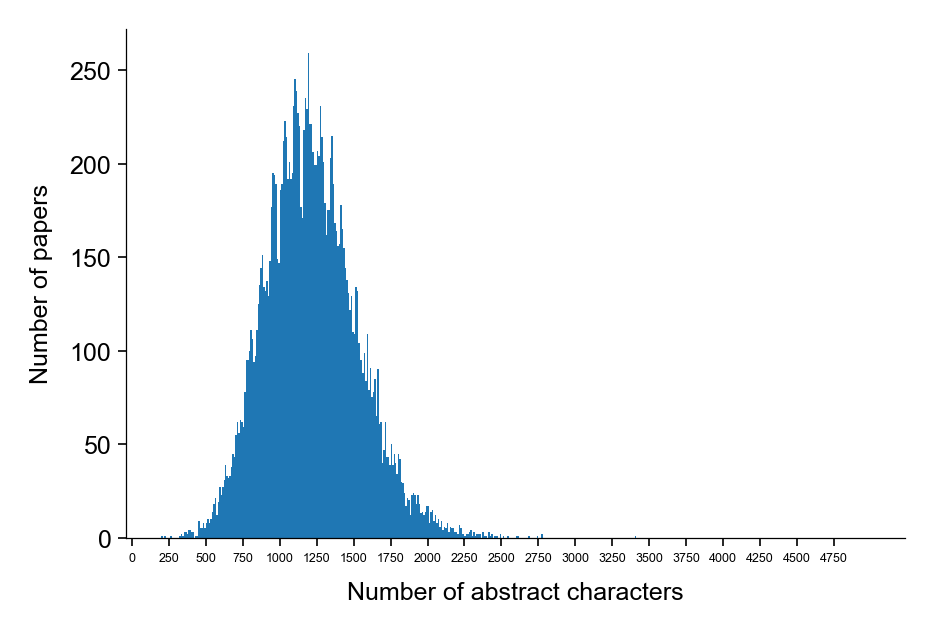

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.hist(bins_characters[:-1], bins_characters, weights=counts_characters)
ax.set_ylabel("Number of papers")
ax.set_xlabel("Number of abstract characters")
ax.set_xticks(np.arange(0, 5000, 250))
ax.set_xticklabels(np.arange(0, 5000, 250), fontsize=3)
# ax.set_xlim(0, 3500)
# ax.set_ylim(0, 350 * 1e3)

## test: Fraction of the whole length

In [ ]:
print(abstracts[0])
test_abstract = [
    "In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.",
    "We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.",
]

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.


In [ ]:
tokenizer_kwargs = dict(
    max_length=512,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

In [ ]:
sentences_tok = tokenizer(
    test_abstract, **tokenizer_kwargs, return_special_tokens_mask=True
)  # .to(device)

In [ ]:
sentences_tok  # .keys()

{'input_ids': tensor([[  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
          2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
          2015,  2855,  1012,   102,     0,     0,     0,     0,     0],
        [  101,  2057,  8970,  1037,  2291,  2000, 10197,  1037,  6778,  1005,
          1055,  2723,  2504,  3081,  2037,  4684,  5080,  1005,  1055, 13617,
          2951,  1999,  1037,  2048,  1011,  3357,  2832,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
mask_token_index = torch.where(
    sentences_tok["input_ids"] == tokenizer.mask_token_id
)[1]

In [ ]:
type(tokenizer.mask_token_id)

int

In [ ]:
tokenizer.mask_token

'[MASK]'

In [ ]:
tokens = sentences_tok["input_ids"][0]
att_mask = sentences_tok["attention_mask"][0]
special_tokens_mask = sentences_tok["special_tokens_mask"][0]
print(tokens)
print(att_mask)
print(special_tokens_mask)


tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,   102,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1])


In [ ]:
print(att_mask.size())
print(int(att_mask.sum()))
print(tokens[int(att_mask.sum()) - 1])

torch.Size([29])
24
tensor(102)


In [ ]:
special_tokens_mask

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1])

In [ ]:
tokens

tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,   102,     0,     0,     0,     0,     0])

In [ ]:
seed = 42
rng = np.random.default_rng(seed)

In [ ]:
mask = np.zeros(len(tokens), dtype=int)
prob = 0.2
mask[: round(len(tokens) * prob)] = 1
rng.shuffle(mask)
torch.from_numpy(mask)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1])

In [ ]:
test = torch.ones(att_mask.size(), dtype=int) * 103

In [ ]:
torch.where((special_tokens_mask == 0) & (mask == 1), test, tokens)

tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,   103,   103,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,   102,     0,     0,     0,     0,     0])

In [ ]:
# joined: FINAL
mask = np.zeros(total_len, dtype=int)
mask[: round(total_len * fraction_masked)] = 1
rng.shuffle(mask)
torch.from_numpy(mask)

test = torch.ones(att_mask.size(), dtype=int) * 103

sentences_1_masked = torch.where((special_tokens_mask == 0) & (mask == 1), test, tokens)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0])

In [ ]:
# import torch
class MaskedAbstractDataset(torch.utils.data.Dataset):
    """FRACTION OF THE WHOLE LENGTH
    THIS CLASS NEEDS CORRECTIONS OF MOVING THE THINGS OF GETITEM TO THE DEVICE LIKE THE CLASS THAT USES THE FRACTION OF THE INDIVIDUAL ABSTRACS
    
    """
    def __init__(self, abstracts, tokenizer, device, tokenizer_kwargs=None, fraction_masked = 0.4, seed=42):
        # actually a list of tokens
        self.abstracts = abstracts
        self.rng = np.random.default_rng(seed)
        self.fraction_masked = fraction_masked

        if tokenizer_kwargs is None:
            tokenizer_kwargs = dict(
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_special_tokens_mask=True, # this one is new and important for this class
            )

        self.abstracts_tok = tokenizer(
            self.abstracts, **tokenizer_kwargs
        ).to(device)

        
    def __getitem__(self, idx):
        """
        In this function you input a index idx and it selects ...
        """
        # get original abstracts and masks
        abstract = self.abstracts_tok["input_ids"][idx]
        amask = self.abstracts_tok["attention_mask"][idx]
        special_tokens_mask = self.abstracts_tok["special_tokens_mask"][idx]

        masked_token_value = torch.ones(abstract.size(), dtype=int) * 103

        # masked abstract 1 -- maybe make this into function; ask Nik
        mask_1 = np.zeros(len(abstract), dtype=int)
        mask_1[: round(len(abstract) * self.fraction_masked)] = 1 
        self.rng.shuffle(mask_1)
        torch.from_numpy(mask_1)

        abstract_1 = torch.where((special_tokens_mask == 0) & (mask_1 == 1), masked_token_value, abstract)

         # masked abstract 2 -- maybe make this into function; ask Nik
        mask_2 = np.zeros(len(abstract), dtype=int)
        mask_2[: round(len(abstract) * self.fraction_masked)] = 1
        self.rng.shuffle(mask_2)
        torch.from_numpy(mask_2)

        abstract_2 = torch.where((special_tokens_mask == 0) & (mask_2 == 1), masked_token_value, abstract)

        return (abstract_1, amask), (abstract_2, amask)

    def __len__(self):
        return len(self.abstracts)

## test: Fraction of the individual abstract length

In [ ]:
print(abstracts[0])
test_abstract = [
    "In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.",
    "We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.",
]

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.


In [ ]:
tokenizer_kwargs = dict(
    max_length=512,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

In [ ]:
sentences_tok = tokenizer(
    test_abstract, **tokenizer_kwargs, return_special_tokens_mask=True
)  # .to(device)

In [ ]:
sentences_tok  # .keys()

{'input_ids': tensor([[  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
          2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
          2015,  2855,  1012,   102,     0,     0,     0,     0,     0],
        [  101,  2057,  8970,  1037,  2291,  2000, 10197,  1037,  6778,  1005,
          1055,  2723,  2504,  3081,  2037,  4684,  5080,  1005,  1055, 13617,
          2951,  1999,  1037,  2048,  1011,  3357,  2832,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'special_tokens_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
tokens = sentences_tok["input_ids"][0]
att_mask = sentences_tok["attention_mask"][0]
special_tokens_mask = sentences_tok["special_tokens_mask"][0]
print(tokens)
print(att_mask)
print(special_tokens_mask)

tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,   102,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1])


In [ ]:
len(np.arange(4))

4

In [ ]:
print(att_mask.size())
print(int(att_mask.sum()))
print(tokens[int(att_mask.sum()) - 1])

torch.Size([29])
24
tensor(102)


In [ ]:
special_tokens_mask

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1])

In [ ]:
int((special_tokens_mask == 0).sum())

22

In [ ]:
tokens

tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,   102,     0,     0,     0,     0,     0])

In [ ]:
seed = 42
rng = np.random.default_rng(seed)

In [ ]:
a = np.arange(4)
print(a, a.shape)
np.pad(a, (1, 8 - len(a) - 1))

[0 1 2 3] (4,)


array([0, 0, 1, 2, 3, 0, 0, 0])

In [ ]:
#BUENO
total_len = int((special_tokens_mask == 0).sum())
prob = 0.2

mask = np.zeros(total_len, dtype=int)
mask[: round(total_len * prob)] = 1
rng.shuffle(mask)
print(mask.shape)
print(mask)

mask = np.pad(mask, (1, len(tokens) - total_len - 1))
print(mask.shape)
torch.from_numpy(mask)

(22,)
[1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
(29,)


tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

In [ ]:
# import torch
class MaskedAbstractDataset(torch.utils.data.Dataset):
    """FRACTION OF THE INDIVIDUAL ABSTRACT LENGTH"""

    def __init__(
        self,
        abstracts,
        tokenizer,
        device,
        tokenizer_kwargs=None,
        fraction_masked=0.4,
        seed=42,
    ):
        # actually a list of tokens
        self.abstracts = abstracts
        self.rng = np.random.default_rng(seed)
        self.fraction_masked = fraction_masked

        if tokenizer_kwargs is None:
            tokenizer_kwargs = dict(
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_special_tokens_mask=True,  # this one is new and important for this class
            )

        self.abstracts_tok = tokenizer(self.abstracts, **tokenizer_kwargs).to(
            device
        )

    def __getitem__(self, idx):
        """
        In this function you input a index idx and it selects ...
        """
        # get original abstracts and masks
        abstract = self.abstracts_tok["input_ids"][idx]
        amask = self.abstracts_tok["attention_mask"][idx]
        special_tokens_mask = self.abstracts_tok["special_tokens_mask"][idx]

        masked_token_value = (
            torch.ones(abstract.size(), dtype=int, device=device) * 103
        )
        real_abstract_length = int((special_tokens_mask == 0).sum())

        # masked abstract 1 -- maybe make this into function; ask Nik
        mask_1 = np.zeros(real_abstract_length, dtype=int)
        mask_1[: round(real_abstract_length * self.fraction_masked)] = 1
        self.rng.shuffle(mask_1)
        mask_1 = np.pad(
            mask_1, (1, len(abstract) - real_abstract_length - 1)
        )  # pad 1 zero at the beggining for the CLS token, and pad the end to fill until reaching original length
        mask_1 = torch.from_numpy(mask_1).to(device)

        abstract_1 = torch.where(
            (special_tokens_mask == 0) & (mask_1 == 1),
            masked_token_value,
            abstract,
        )

        # masked abstract 2 -- maybe make this into function; ask Nik
        mask_2 = np.zeros(real_abstract_length, dtype=int)
        mask_2[: round(real_abstract_length * self.fraction_masked)] = 1
        self.rng.shuffle(mask_2)
        mask_2 = np.pad(mask_2, (1, len(abstract) - real_abstract_length - 1))
        mask_2 = torch.from_numpy(mask_2).to(device)

        abstract_2 = torch.where(
            (special_tokens_mask == 0) & (mask_2 == 1),
            masked_token_value,
            abstract,
        )

        return (abstract_1, amask), (abstract_2, amask)

    def __len__(self):
        return len(self.abstracts)

### Test class

#### Dummy test

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
print(abstracts[0])
test_abstract = [
    "In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.",
    "We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.",
]
print(test_abstract)

In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. First, we train a neural network to determine when a smartphone enters or exits a building via GPS signal changes. Second, we use a barometer equipped smartphone to measure the change in barometric pressure from the entrance of the building to the victim's indoor location. Unlike impractical previous approaches, our system is the first that does not require the use of beacons, prior knowledge of the building infrastructure, or knowledge of user behavior. We demonstrate real-world feasibility through 63 experiments across five different tall buildings throughout New York City where our system predicted the correct floor level with 100% accuracy.
['In cities with tall buildings, emergency responders need an accurate floor level location to find 911 caller

In [ ]:
tokenizer_kwargs = dict(
    max_length=512,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

In [ ]:
abstracts_tok = tokenizer(
    test_abstract, **tokenizer_kwargs, return_special_tokens_mask=True
).to(device)

In [ ]:
seed = 42
rng = np.random.default_rng(seed)
fraction_masked = 0.4
idx = 1

In [ ]:
abstract = abstracts_tok["input_ids"][idx]
amask = abstracts_tok["attention_mask"][idx]
special_tokens_mask = abstracts_tok["special_tokens_mask"][idx]

masked_token_value_1 = (
    torch.ones(abstract.size(), dtype=int, device=device) * 103
)
real_sentences_length_1 = int((special_tokens_mask == 0).sum())

# masked abstract 1 -- maybe make this into function; ask Nik
mask_1 = np.zeros(real_sentences_length_1, dtype=int)
mask_1[: round(real_sentences_length_1 * fraction_masked)] = 1
rng.shuffle(mask_1)
mask_1 = np.pad(
    mask_1, (1, len(abstract) - real_sentences_length_1 - 1)
)  # pad 1 zero at the beggining for the CLS token, and pad the end to fill until reaching original length
mask_1 = torch.from_numpy(mask_1).to(device)

sentences_1_masked = torch.where(
    (special_tokens_mask == 0) & (mask_1 == 1), masked_token_value_1, abstract
)

# masked abstract 2 -- maybe make this into function; ask Nik
mask_2 = np.zeros(real_sentences_length_1, dtype=int)
mask_2[: round(real_sentences_length_1 * fraction_masked)] = 1
rng.shuffle(mask_2)
mask_2 = np.pad(mask_2, (1, len(abstract) - real_sentences_length_1 - 1))
mask_2 = torch.from_numpy(mask_2).to(device)

sentences_2_masked = torch.where(
    (special_tokens_mask == 0) & (mask_2 == 1), masked_token_value_1, abstract
)

In [ ]:
print(abstract)
print(sentences_1_masked)
print(sentences_2_masked)

tensor([  101,  2057,  8970,  1037,  2291,  2000, 10197,  1037,  6778,  1005,
         1055,  2723,  2504,  3081,  2037,  4684,  5080,  1005,  1055, 13617,
         2951,  1999,  1037,  2048,  1011,  3357,  2832,  1012,   102])
tensor([  101,   103,  8970,  1037,  2291,  2000,   103,  1037,  6778,  1005,
          103,   103,   103,  3081,   103,   103,  5080,  1005,  1055, 13617,
         2951,  1999,   103,   103,  1011,   103,  2832,   103,   102])
tensor([  101,   103,   103,   103,  2291,  2000,   103,  1037,  6778,  1005,
          103,  2723,   103,  3081,   103,   103,  5080,  1005,   103, 13617,
         2951,  1999,  1037,  2048,  1011,  3357,   103,   103,   102])


In [ ]:
print(type(abstract))
print(type(sentences_1_masked))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


#### Real test: WORKS

In [ ]:
# RUN CLASS ABOVE

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
%%time
# data
training_dataset = MaskedAbstractDataset(
    iclr.abstract.tolist(), tokenizer, device, fraction_masked=0.4, seed=42
)

CPU times: user 31.2 s, sys: 4.9 s, total: 36.1 s
Wall time: 4.63 s


In [ ]:
print(len(iclr.abstract))
print(len(training_dataset))

16536
16536


In [ ]:
test_sample = training_dataset[0]

In [ ]:
print(test_sample[0][0])
print(test_sample[1][0])

tensor([  101,  1999,   103,  2007,  4206,   103,   103,  5057,  6869,   103,
          103,  2019,   103,  2723,   103,   103,  2000,  2424,   103, 20587,
         2015,  2855,  1012,  2057,  8970,   103,  2291,   103,   103,  1037,
          103,   103,   103,  2723,   103,  3081,  2037,   103,  5080,  1005,
          103,   103,  2951,  1999,   103,   103,  1011,   103,  2832,  1012,
         2034,   103,  2057,  3345,  1037,   103,  2897,  2000,   103,  2043,
         1037, 26381,  8039,  2030, 16639,  1037,  2311,   103, 14658,  4742,
          103,  1012,   103,  1010,  2057,  2224,  1037,  3347, 18721,  6055,
        26381,  2000,   103,  1996,   103,  1999,  3347, 28993,  3778,  2013,
         1996,   103,  1997,  1996,   103,   103,  1996,  6778,  1005,  1055,
          103,  3295,  1012,  4406, 17727, 22648,   103,  3025,   103,   103,
         2256,   103,  2003,   103,   103,   103,  2515,   103,  5478,  1996,
          103,  1997, 14400,  2015,  1010,  3188,   103,  1997, 

In [ ]:
(test_sample[0][0] == 103).sum() / (test_sample[0][0] != 0).sum()

tensor(0.3941, device='cuda:0')

In [ ]:
[elem[:6] for elem in ["Hola", "Holaa", "Holaaaa"]]

['Hola', 'Holaa', 'Holaaa']

In [ ]:
%%time
[elem[:1000] for elem in abstracts]

NameError: name 'abstracts' is not defined

# MaskedMultOverlappingSentencesPairDataset

In [ ]:
import itertools


class MaskedMultOverlappingSentencesPairDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        abstracts,
        tokenizer,
        device,
        n_cons_sntcs=2,
        tokenizer_kwargs=None,
        fraction_masked=0.4,
        seed=42,
    ):
        # actually a list of tokens
        self.abstracts = abstracts
        self.rng = np.random.default_rng(seed)
        self.n_cons_sntcs = n_cons_sntcs
        self.device = device
        self.fraction_masked = fraction_masked

        # sentence map
        self.sentences_map = []
        for i, sentences in enumerate(
            abstracts.map(lambda a: a.split("."))
        ):  # loop through abstracts
            for j in range(
                len(sentences) - (self.n_cons_sntcs - 1)
            ):  # loop through sentences inside abstract
                if (len(sentences[j]) >= 100) & (
                    len(sentences[j]) <= 250
                ):  # length conditions
                    cons_sentences_pack = ""
                    cons_sentence_counts = 0
                    for k in range(
                        len(sentences) - j
                    ):  # loop through sentences to add them
                        if (len(sentences[j + k]) >= 100) & (
                            len(sentences[j + k]) <= 250
                        ):  # length conditions
                            cons_sentences_pack += (
                                sentences[j + k].strip() + ". "
                            )
                            cons_sentence_counts += 1

                        if (
                            cons_sentence_counts == self.n_cons_sntcs
                        ):  # check if we have already enough sentences
                            self.sentences_map.append((cons_sentences_pack, i))
                            break

        if tokenizer_kwargs is None:
            tokenizer_kwargs = dict(
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_special_tokens_mask=True,  # this one is new and important for this class
            )

        self.sentences_tok = tokenizer(
            [x for x, _ in self.sentences_map], **tokenizer_kwargs
        ).to(self.device)

        # we group the flat sentences by the original abstract they
        # come from.  Then we can check whether we have enough
        # sentences and append the abstracts with at least two
        # sentences to our list.
        sentences_and_toks = zip(
            self.sentences_map,
            self.sentences_tok["input_ids"],
            self.sentences_tok["attention_mask"],
            self.sentences_tok["special_tokens_mask"],
        )
        self.abs_sentences = []
        self.abs_toks = []
        self.abs_mask = []
        self.abs_special_msk = []
        for key, group in itertools.groupby(
            sentences_and_toks,
            key=lambda kvtoksetc: kvtoksetc[0][
                1
            ],  # this is selecting the index from the abstract from the tuple inside sentences_map
        ):
            grp = list(group)
            if len(grp) < 2:
                continue  # not enough sentences
            else:
                self.abs_sentences.append([kv[0] for kv in grp])
                self.abs_toks.append([x[1] for x in grp])
                self.abs_mask.append([x[2] for x in grp])
                self.abs_special_msk.append([x[3] for x in grp])

        # we now have `self.abs_toks`, which is a list of lists,
        # where the first list is the abstracts and the second is the
        # token representation of the sentences within the given
        # abstract.

    def __getitem__(self, idx):
        abstract = self.abs_toks[idx]
        amask = self.abs_mask[idx]
        special_tokens_mask = self.abs_special_msk[idx]
        i1, i2 = self.rng.choice(len(abstract), size=2, replace=False)

        # select pair of cons sentences
        sentences_1 = abstract[i1]
        amask_1 = amask[i1]
        special_tokens_mask_1 = special_tokens_mask[i1]
        sentences_2 = abstract[i2]
        amask_2 = amask[i2]
        special_tokens_mask_2 = special_tokens_mask[i2]

        # sentences 1
        masked_token_value_1 = (
            torch.ones(sentences_1.size(), dtype=int, device=self.device) * 103
        )
        real_sentences_length_1 = int((special_tokens_mask_1 == 0).sum())

        # masked sentences 1 -- maybe make this into function; ask Nik
        mask_1 = np.zeros(real_sentences_length_1, dtype=int)
        mask_1[: round(real_sentences_length_1 * self.fraction_masked)] = 1
        self.rng.shuffle(mask_1)
        mask_1 = np.pad(
            mask_1, (1, len(sentences_1) - real_sentences_length_1 - 1)
        )  # pad 1 zero at the beggining for the CLS token, and pad the end to fill until reaching original length
        mask_1 = torch.from_numpy(mask_1).to(self.device)

        sentences_1_masked = torch.where(
            (special_tokens_mask_1 == 0) & (mask_1 == 1),
            masked_token_value_1,
            sentences_1,
        )

        # sentences 2
        masked_token_value_2 = (
            torch.ones(sentences_2.size(), dtype=int, device=self.device) * 103
        )
        real_sentences_length_2 = int((special_tokens_mask_2 == 0).sum())

        # masked sentences 2 -- maybe make this into function; ask Nik
        mask_2 = np.zeros(real_sentences_length_2, dtype=int)
        mask_2[: round(real_sentences_length_2 * self.fraction_masked)] = 1
        self.rng.shuffle(mask_2)
        mask_2 = np.pad(
            mask_2, (1, len(sentences_2) - real_sentences_length_2 - 1)
        )
        mask_2 = torch.from_numpy(mask_2).to(self.device)

        sentences_2_masked = torch.where(
            (special_tokens_mask_2 == 0) & (mask_2 == 1),
            masked_token_value_2,
            sentences_2,
        )

        return (sentences_1_masked, amask_1), (sentences_2_masked, amask_2)

    def __len__(self):
        return len(self.abs_sentences)

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
i = 0
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_names[i])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
# model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  BERT
Running on device: cuda
bert-base-uncased


In [ ]:
%%time
# data
training_dataset_test_len = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

CPU times: user 51.7 s, sys: 17.6 s, total: 1min 9s
Wall time: 6.63 s


In [ ]:
print(len(training_dataset_test_len))

15931


In [ ]:
%%time
# data
training_dataset = MaskedMultOverlappingSentencesPairDataset(
    iclr.abstract,
    tokenizer,
    device,
    n_cons_sntcs=2,
    fraction_masked=0.4,
    seed=42,
)

CPU times: user 55.9 s, sys: 21.7 s, total: 1min 17s
Wall time: 7.95 s


In [ ]:
print(len(iclr.abstract))
print(len(training_dataset))

16536
15931


In [ ]:
training_dataset.abs_sentences[0][0]

("In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly. We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process. ",
 0)

In [ ]:
training_dataset.abs_toks[0][0]

tensor([  101,  1999,  3655,  2007,  4206,  3121,  1010,  5057,  6869,  2545,
         2342,  2019,  8321,  2723,  2504,  3295,  2000,  2424, 19989, 20587,
         2015,  2855,  1012,  2057,  8970,  1037,  2291,  2000, 10197,  1037,
         6778,  1005,  1055,  2723,  2504,  3081,  2037,  4684,  5080,  1005,
         1055, 13617,  2951,  1999,  1037,  2048,  1011,  3357,  2832,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
test_sample = training_dataset[0]

In [ ]:
print(test_sample[0][0])
print(test_sample[1][0])

tensor([  101,  1999,   103,  2007,  4206,   103,   103,   103,   103,  2545,
         2342,  2019,  8321,  2723,   103,  3295,  2000,  2424, 19989,   103,
         2015,  2855,  1012,  2057,   103,  1037,  2291,  2000, 10197,   103,
         6778,  1005,   103,   103,  2504,   103,  2037,   103,   103,  1005,
          103, 13617,   103,   103,  1037,   103,   103,   103,  2832,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 